# Load Datasets

In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.metrics import Precision, Recall
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

2025-10-23 21:59:36.114620: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761256776.407876      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761256776.487051      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os

def get_data_path(slug_name):
    base1 = f"/kaggle/input/{slug_name}"
    base2 = "/kaggle/input"
    if os.path.exists(base1):
        return base1
    elif os.path.exists(base2):
        return base2
    else:
        return "./Data"

data_dir = get_data_path("international-hotel-booking-analytics")

users = pd.read_csv(f"{data_dir}/users.csv")
hotels = pd.read_csv(f"{data_dir}/hotels.csv")
reviews = pd.read_csv(f"{data_dir}/reviews.csv")

# Data Cleaning

In [3]:
def clean_data(hotels, reviews, users):
    # merge all datasets
    tmp_df = pd.merge(hotels, reviews, on='hotel_id')
    df = pd.merge(tmp_df, users, on='user_id')
    
    # rename columns
    df.rename(columns={'country_x': 'hotel_country', 'country_y': 'user_country'}, inplace=True)

    # convert to datetime
    df['review_date'] = pd.to_datetime(df['review_date'])
    df['join_date'] = pd.to_datetime(df['join_date'])
    
    # clean NaNs and duplicates
    df = df.drop_duplicates()
    numeric_cols = df.select_dtypes(include=['number']).columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())
    text_cols = df.select_dtypes(include=['object']).columns
    df[text_cols] = df[text_cols].fillna('Unknown')

    # create mapping before one-hot
    country_to_group = {
        'United States': 'North_America',
        'Canada': 'North_America',
        'Germany': 'Western_Europe',
        'France': 'Western_Europe',
        'United Kingdom': 'Western_Europe',
        'Netherlands': 'Western_Europe',
        'Spain': 'Western_Europe',
        'Italy': 'Western_Europe',
        'Russia': 'Eastern_Europe',
        'China': 'East_Asia',
        'Japan': 'East_Asia',
        'South Korea': 'East_Asia',
        'Thailand': 'Southeast_Asia',
        'Singapore': 'Southeast_Asia',
        'United Arab Emirates': 'Middle_East',
        'Turkey': 'Middle_East',
        'Egypt': 'Africa',
        'Nigeria': 'Africa',
        'South Africa': 'Africa',
        'Australia': 'Oceania',
        'New Zealand': 'Oceania',
        'Brazil': 'South_America',
        'Argentina': 'South_America',
        'India': 'South_Asia',
        'Mexico': 'North_America_Mexico'
    }

    # create the country_group column
    df['country_group'] = df['user_country'].map(country_to_group).fillna('Other')

    # binary mapping for gender
    df['user_gender'] = df['user_gender'].map({'Male': 0, 'Female': 1}).fillna(-1)
    

    
    # drop unnecessary columns
    df = df.drop(columns=[
        'user_id', 'hotel_id', 'review_id','join_date', 'lat', 'lon', 'user_country','hotel_name', 'review_text', 'review_date'
    ], errors='ignore')

    return df
df = clean_data(hotels, reviews, users)

In [4]:
df.head()

,city,hotel_country,star_rating,cleanliness_base,comfort_base,facilities_base,location_base,staff_base,value_for_money_base,score_overall,score_cleanliness,score_comfort,score_facilities,score_location,score_staff,score_value_for_money,user_gender,age_group,traveller_type,country_group
0,New York,United States,5,9.1,8.8,8.9,9.5,8.6,8.0,8.7,8.6,8.7,8.5,9.0,8.8,8.7,1.0,25-34,Solo,Oceania
1,New York,United States,5,9.1,8.8,8.9,9.5,8.6,8.0,8.7,8.8,8.9,8.4,8.9,8.7,8.4,1.0,55+,Solo,Western_Europe
2,New York,United States,5,9.1,8.8,8.9,9.5,8.6,8.0,8.8,8.3,8.6,9.1,9.5,9.1,7.5,0.0,25-34,Business,Oceania
3,New York,United States,5,9.1,8.8,8.9,9.5,8.6,8.0,8.8,9.3,9.4,8.2,9.1,8.3,8.4,-1.0,18-24,Couple,Western_Europe
4,New York,United States,5,9.1,8.8,8.9,9.5,8.6,8.0,8.7,8.2,8.8,8.7,9.4,9.0,7.4,1.0,35-44,Business,Africa


In [5]:
df.columns.tolist()

['city',
 'hotel_country',
 'star_rating',
 'cleanliness_base',
 'comfort_base',
 'facilities_base',
 'location_base',
 'staff_base',
 'value_for_money_base',
 'score_overall',
 'score_cleanliness',
 'score_comfort',
 'score_facilities',
 'score_location',
 'score_staff',
 'score_value_for_money',
 'user_gender',
 'age_group',
 'traveller_type',
 'country_group']

# Data-Engineering Questions

In [6]:
grouped1_df = df.groupby(['traveller_type', 'city'])['score_overall'].mean().reset_index()

In [7]:
grouped2_df = df.groupby(['traveller_type', 'hotel_country'])['score_value_for_money'].mean().reset_index()

In [8]:
n =20
top_n_cities = (
    grouped1_df
    .sort_values(['traveller_type', 'score_overall'], ascending=[True, False])
    .groupby('traveller_type')
    .head(n)
)
top_n_cities.head(20)

,traveller_type,city,score_overall
7,Business,Dubai,8.965668
0,Business,Amsterdam,8.964348
20,Business,Singapore,8.944472
19,Business,Shanghai,8.920833
17,Business,Rome,8.906683
23,Business,Toronto,8.906047
2,Business,Barcelona,8.904545
1,Business,Bangkok,8.886265
24,Business,Wellington,8.881884
18,Business,Seoul,8.881710


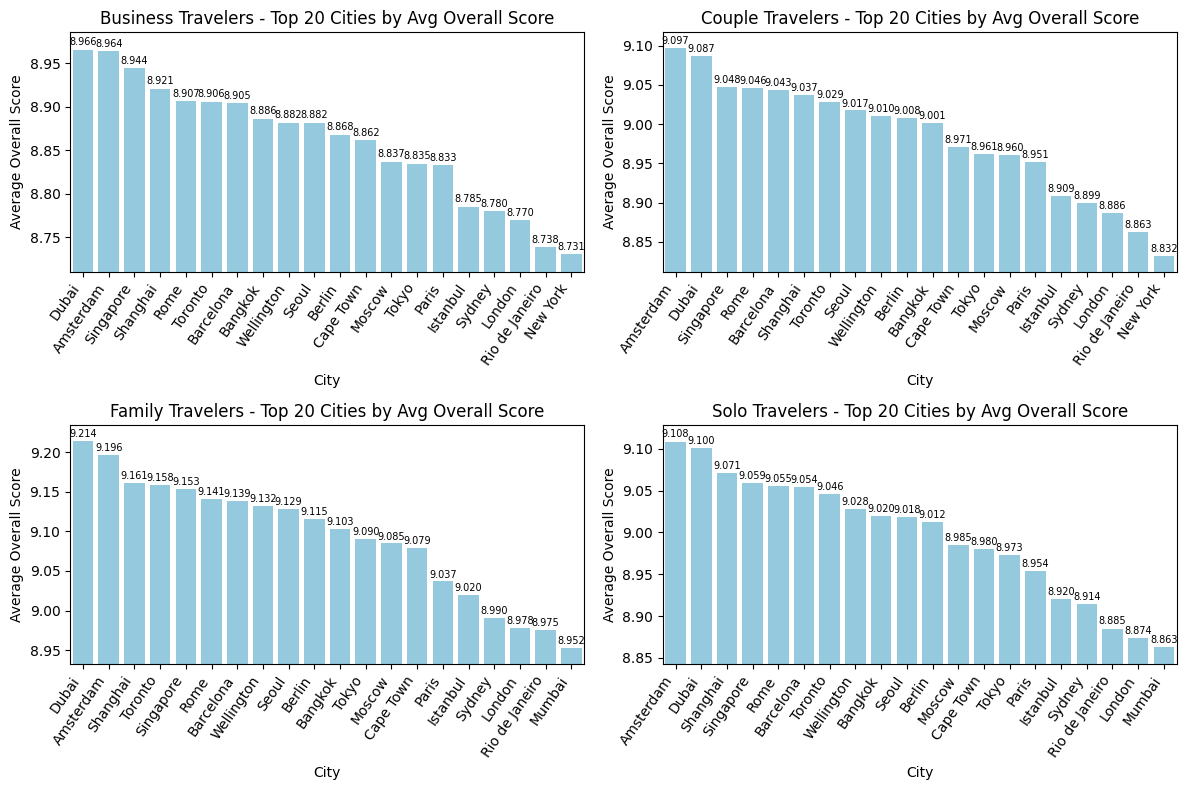

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
traveller_types = top_n_cities['traveller_type'].unique()

for i, ttype in enumerate(traveller_types):
    plt.subplot(2, 2, i + 1)
    subset = top_n_cities[top_n_cities['traveller_type'] == ttype].sort_values('score_overall', ascending=False)
    
    # رسم الأعمدة بشكل رأسي
    sns.barplot(data=subset, x='city', y='score_overall', color='skyblue')
    
    # كتابة القيم فوق الأعمدة
    for index, value in enumerate(subset['score_overall']):
        plt.text(index, value + 0.005, f'{value:.3f}', ha='center', fontsize=7)
    
    plt.title(f'{ttype} Travelers - Top {n} Cities by Avg Overall Score')
    plt.xlabel('City')
    plt.ylabel('Average Overall Score')
    plt.ylim(subset['score_overall'].min() - 0.02, subset['score_overall'].max() + 0.02)
    plt.xticks(rotation=55, ha='right')

plt.tight_layout()
plt.show()


In [10]:
x = 10
top_x_countries = (
    grouped2_df
    .sort_values(['traveller_type', 'hotel_country'], ascending=[True, False])
    .groupby('traveller_type')
    .head(x)
)

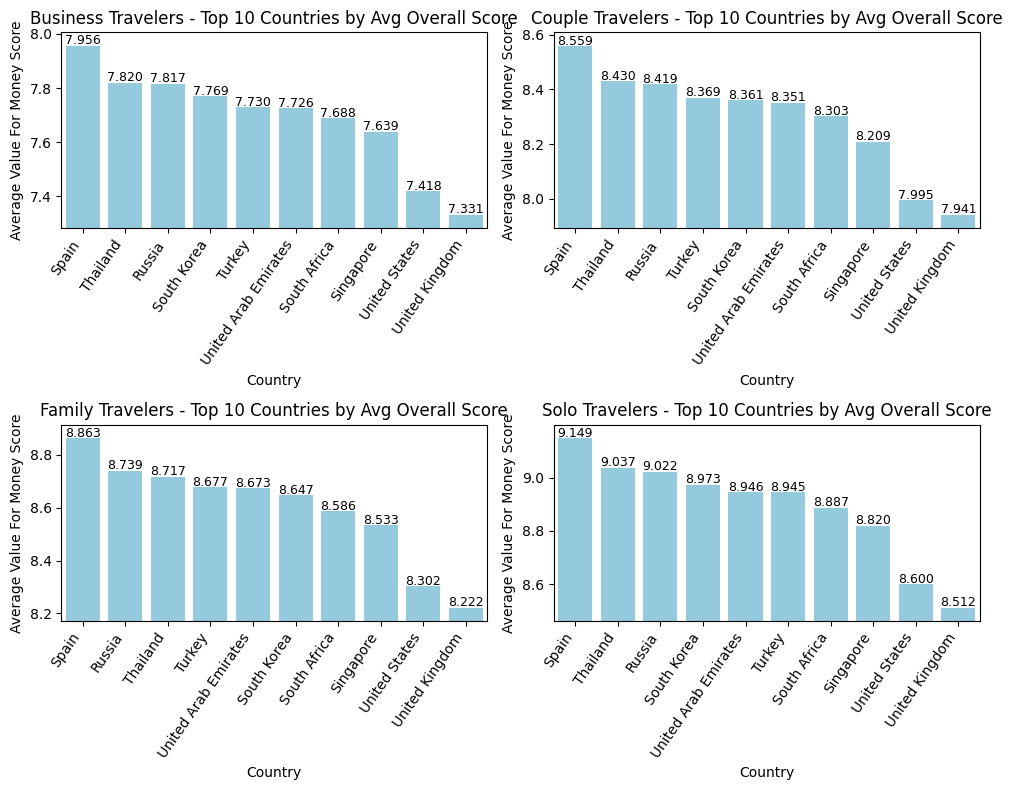

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
traveller_types = top_x_countries['traveller_type'].unique()

for i, ttype in enumerate(traveller_types):
    plt.subplot(2, 2, i + 1)
    subset = top_x_countries[top_x_countries['traveller_type'] == ttype].sort_values('score_value_for_money', ascending=False)
    
    # رسم الأعمدة بشكل رأسي
    sns.barplot(data=subset, x='hotel_country', y='score_value_for_money', color='skyblue')
    
    # كتابة القيم فوق الأعمدة
    for index, value in enumerate(subset['score_value_for_money']):
        plt.text(index, value + 0.005, f'{value:.3f}', ha='center', fontsize=9)
    
    plt.title(f'{ttype} Travelers - Top {x} Countries by Avg Overall Score')
    plt.xlabel('Country')
    plt.ylabel('Average Value For Money Score')
    plt.ylim(subset['score_value_for_money'].min() - 0.05, subset['score_value_for_money'].max() + 0.05)
    plt.xticks(rotation=55, ha='right')

plt.tight_layout()
plt.show()


# Predictive Modeling Task

Here we used a neural network for the predictive modeling since it helps with classifications and groups predictions, as well as being able to utilise a large number of samples, we started with a set that doesn't use the encoded city or age groups but switched from that due to the inconsistency in precision:

features = [
     
    'star_rating',
    'cleanliness_base', 'comfort_base', 'facilities_base',
    'location_base', 'staff_base', 'value_for_money_base',

    
    'score_overall', 'score_cleanliness', 'score_comfort',
    'score_facilities', 'score_location', 'score_staff',
    'score_value_for_money',

     User attributes
    'user_gender',

    'traveller_type_Couple',
    'traveller_type_Family',
    'traveller_type_Solo'
]

Afterwards we tried using sets with all the encoded features including city and age groups as seen below
and eventually the precision for both value and train became more consistent during the last 10 or so epochs after initial fluctuation 


In [12]:
    # one-hot encode categorical columns
    categorical_cols = ['traveller_type', 'age_group', 'city']
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=np.uint8)

In [13]:
X = df[['star_rating',
 'cleanliness_base', 'comfort_base', 'facilities_base',
 'location_base', 'staff_base', 'value_for_money_base',
 'score_overall', 'score_cleanliness', 'score_comfort', 'score_facilities',
 'score_location', 'score_staff', 'score_value_for_money', 'user_gender',
 'traveller_type_Couple', 'traveller_type_Family', 'traveller_type_Solo',
 'age_group_25-34', 'age_group_35-44', 'age_group_45-54', 'age_group_55+',
 'city_Bangkok', 'city_Barcelona', 'city_Berlin', 'city_Buenos Aires',
 'city_Cairo', 'city_Cape Town', 'city_Dubai', 'city_Istanbul', 'city_Lagos',
 'city_London', 'city_Mexico City', 'city_Moscow', 'city_Mumbai', 'city_New York',
 'city_Paris', 'city_Rio de Janeiro', 'city_Rome', 'city_Seoul', 'city_Shanghai',
 'city_Singapore', 'city_Sydney', 'city_Tokyo', 'city_Toronto', 'city_Wellington']]

y = df['country_group']

In [14]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

y_categorical = to_categorical(y_encoded)
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical,
test_size=0.2, random_state=42)
print("\nLabel-encoded (numeric) y:")
print(y_encoded)

print("\nOne-hot encoded y (matrix):")
print(y_categorical)


Label-encoded (numeric) y:
[ 6 10  6 ... 10 10 10]

One-hot encoded y (matrix):
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [15]:
model = Sequential([Input(shape=(X_train.shape[1],)),
layers.Dense(128, activation='relu'),
layers.Dense(64, activation='relu'),
layers.Dense(y_train.shape[1], activation='softmax') 
])
model.summary()

2025-10-23 21:59:56.257480: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         6,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 11)             │           715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,987 (58.54 KB)

 Trainable params: 14,987 (58.54 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.compile(optimizer='adam',
loss='categorical_crossentropy',
metrics=['accuracy',
Precision(name='precision'),
Recall(name='recall')])


In [17]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_accuracy', patience=3,
restore_best_weights=True)
history = model.fit(X_train, y_train,
epochs=50,
validation_split=0.2,
verbose=1,
callbacks=[early_stop])

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.3189 - loss: 2.0475 - precision: 0.3459 - recall: 0.0146 - val_accuracy: 0.3275 - val_loss: 1.9727 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3341 - loss: 1.9715 - precision: 0.0680 - recall: 2.7224e-05 - val_accuracy: 0.3309 - val_loss: 1.9762 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3434 - loss: 1.9618 - precision: 0.4619 - recall: 4.1519e-04 - val_accuracy: 0.3309 - val_loss: 1.9631 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3401 - loss: 1.9660 - precision: 0.0292 - recall: 1.0657e-05 - val_accuracy: 0.3309 - val_loss: 1.9705 - val_precision: 0.4471 - val_recall: 0.0306
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3417 - loss: 1.9556 - precision: 0.5677 - recall

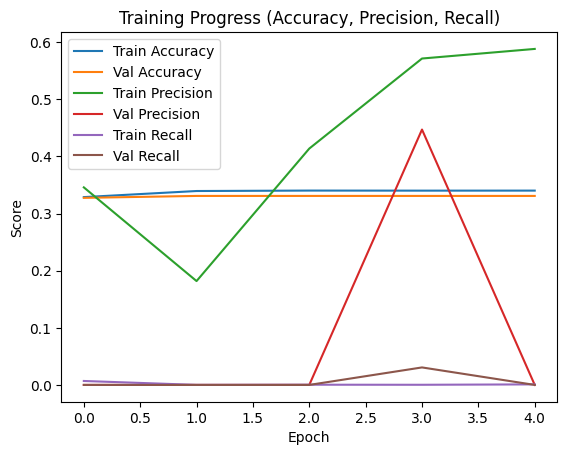

In [18]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Val Precision')
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Val Recall')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Training Progress (Accuracy, Precision, Recall)')
plt.legend()
plt.show()


In [19]:
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test,
y_test, verbose=0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)

from sklearn.metrics import f1_score, classification_report
import numpy as np


y_pred = model.predict(X_test)

y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

f1_macro = f1_score(y_true_classes, y_pred_classes, average='macro')
f1_weighted = f1_score(y_true_classes, y_pred_classes, average='weighted')

print("F1 (macro):", f1_macro)
print("F1 (weighted):", f1_weighted)

print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))



Test Loss: 1.9822925329208374
Test Accuracy: 0.33059999346733093
Test Precision: 0.0
Test Recall: 0.0
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
F1 (macro): 0.04517442575461514
F1 (weighted): 0.1642813166992334

Classification Report:
                      precision    recall  f1-score   support

              Africa       0.00      0.00      0.00       294
           East_Asia       0.00      0.00      0.00      1625
      Eastern_Europe       0.00      0.00      0.00       270
         Middle_East       0.00      0.00      0.00       475
       North_America       0.00      0.00      0.00      1930
North_America_Mexico       0.00      0.00      0.00       238
             Oceania       0.00      0.00      0.00       616
       South_America       0.00      0.00      0.00       667
          South_Asia       0.00      0.00      0.00       335
      Southeast_Asia       0.00      0.00      0.00       244
      Western_Europe       0.33      1.00      0.50      3306

            accuracy 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Model Explainability

In [20]:
import shap
shap.initjs()

import lime
import lime.lime_tabular

In [21]:
background = shap.sample(X_train, 100, random_state=42)
explainer = shap.Explainer(model, background)
shap_values = explainer(X_test[0:100])

PermutationExplainer explainer: 101it [00:11,  1.90it/s]                        



# Absolute Mean SHAP
This plot shows the contribution of each feature globally and ranks them

Classes: ['Africa' 'East_Asia' 'Eastern_Europe' 'Middle_East' 'North_America'
 'North_America_Mexico' 'Oceania' 'South_America' 'South_Asia'
 'Southeast_Asia' 'Western_Europe']


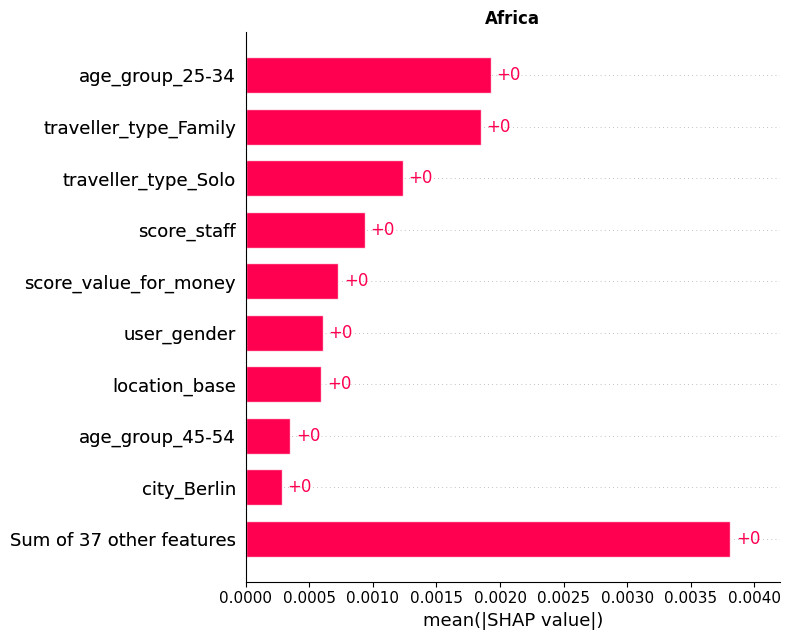

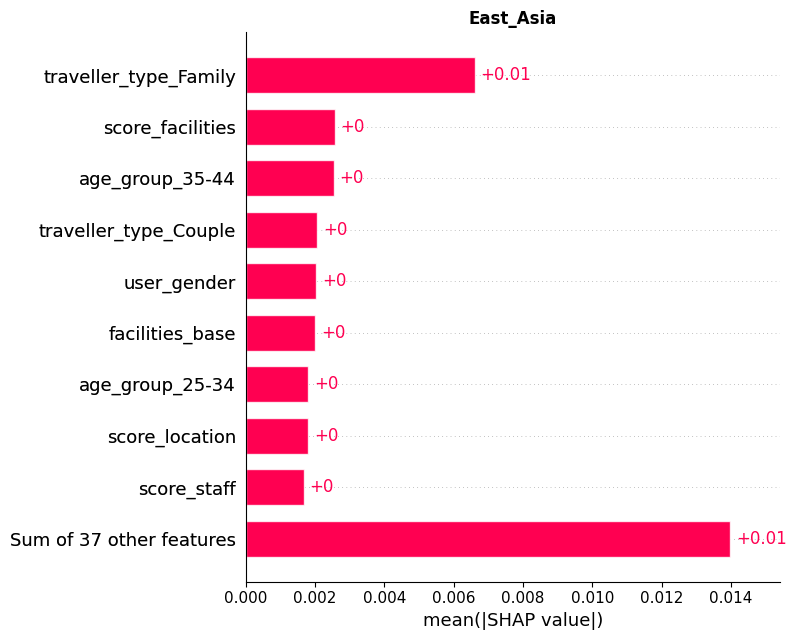

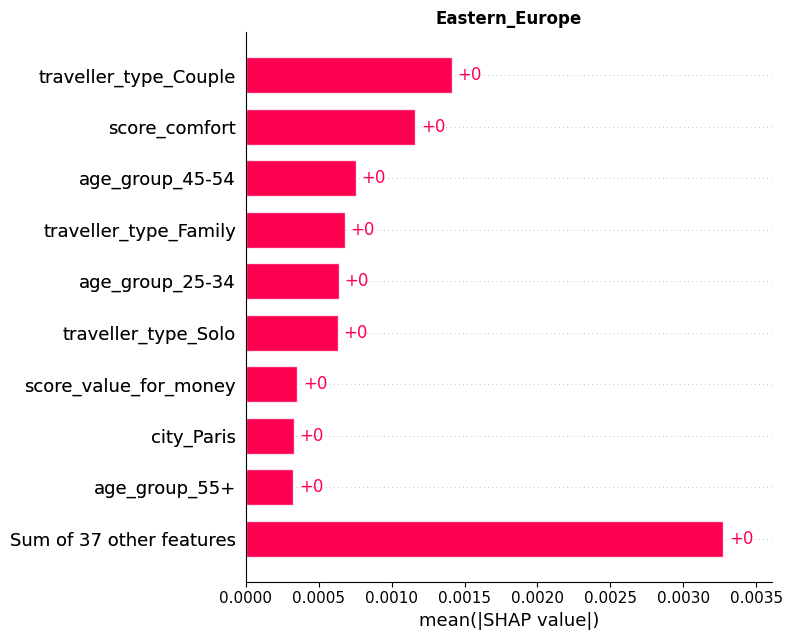

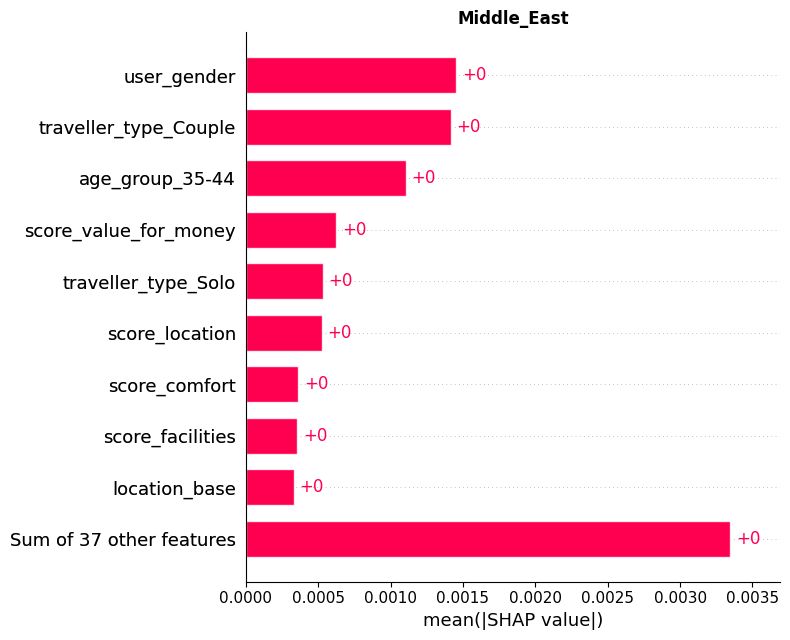

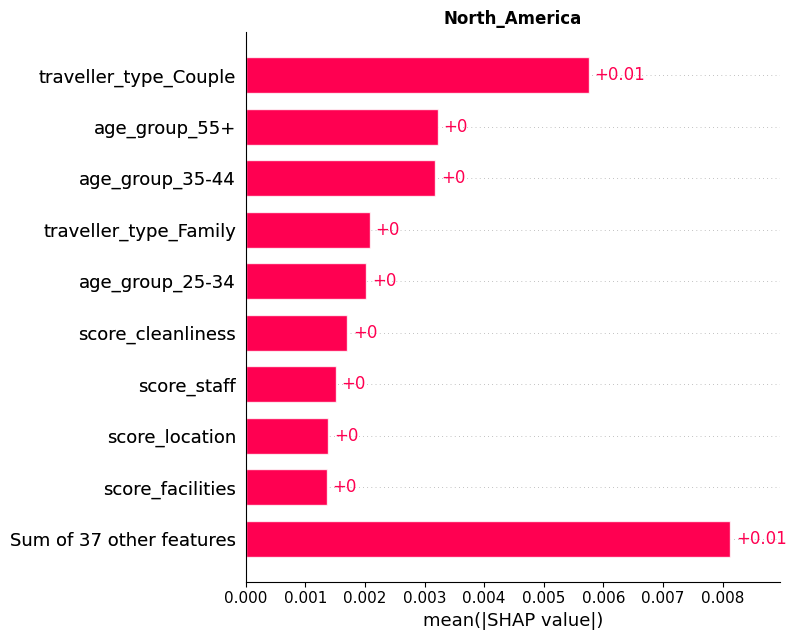

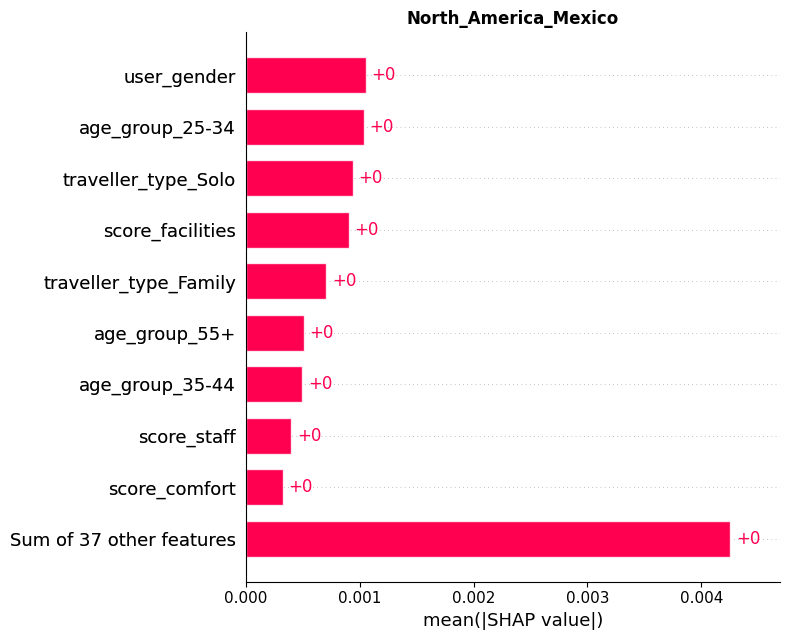

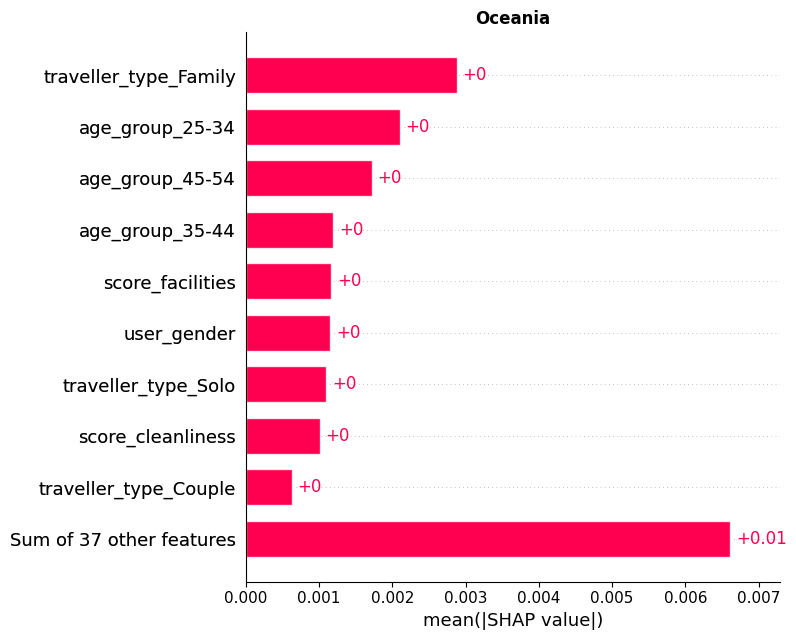

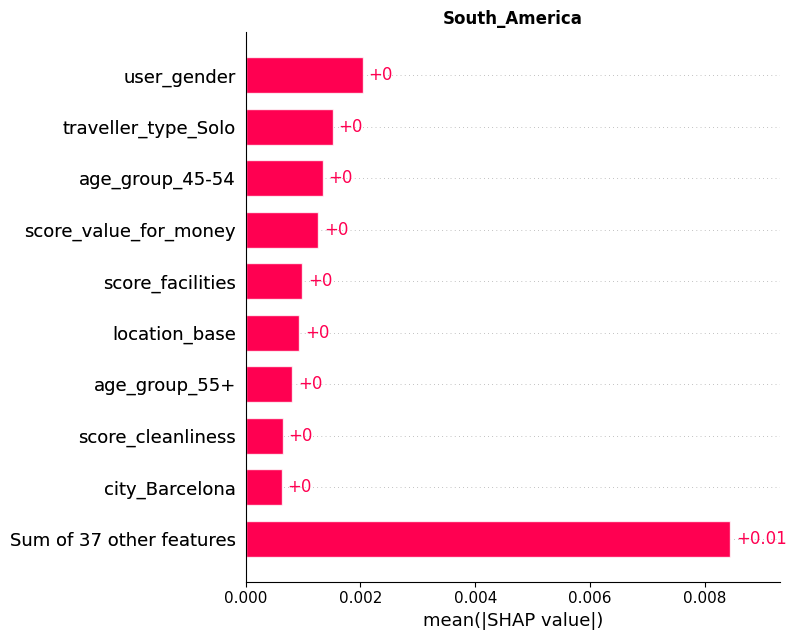

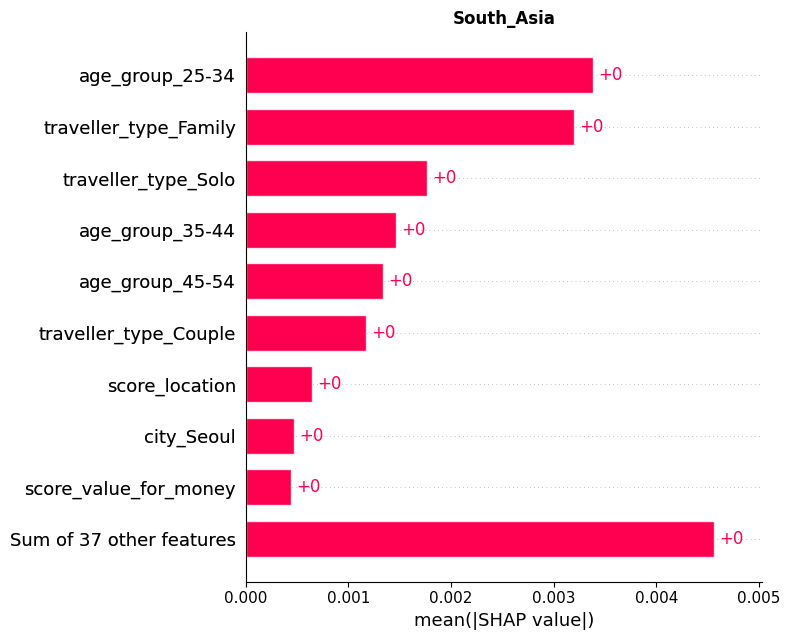

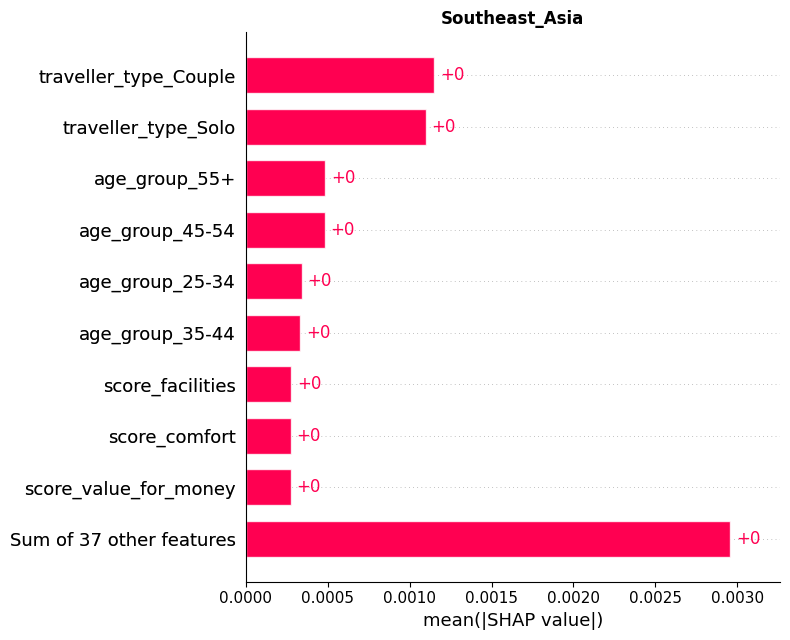

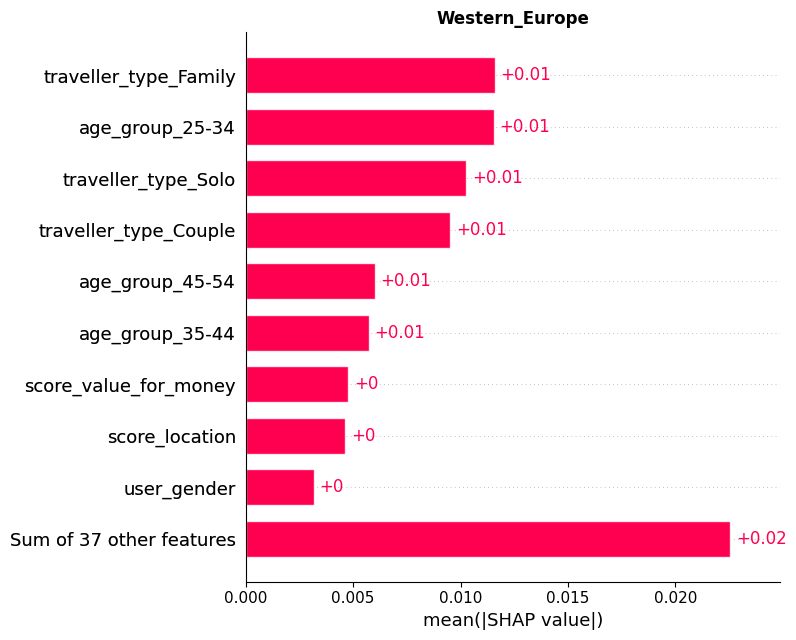

In [22]:

class_names = label_encoder.classes_
print("Classes:", class_names)

for class_idx in range(11):
    # Extract SHAP values for this specific class
    shap_values_class = shap_values[:, :, class_idx]
    
    # Create bar plot for this class
    fig, ax = plt.subplots(figsize=(16, 6))  # new figure and axis
    shap.plots.bar(shap_values_class, show=False)
    ax.set_title(f'{class_names[class_idx]}', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()


# Waterfall Plot
This plot shows the contribution of each feature, moving it from the baseline value, to the prediction value

# Force Plot
This is a similar perspective, in a different format
from IPython.display import display

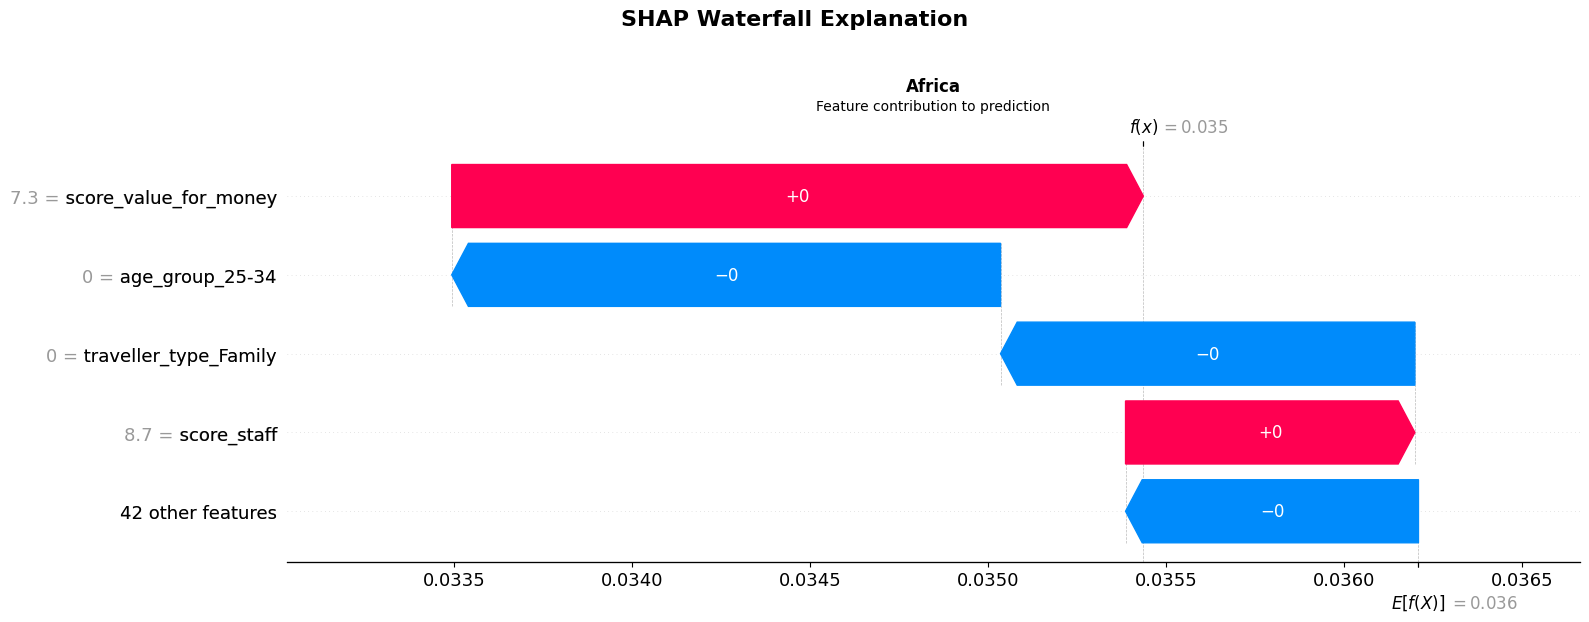

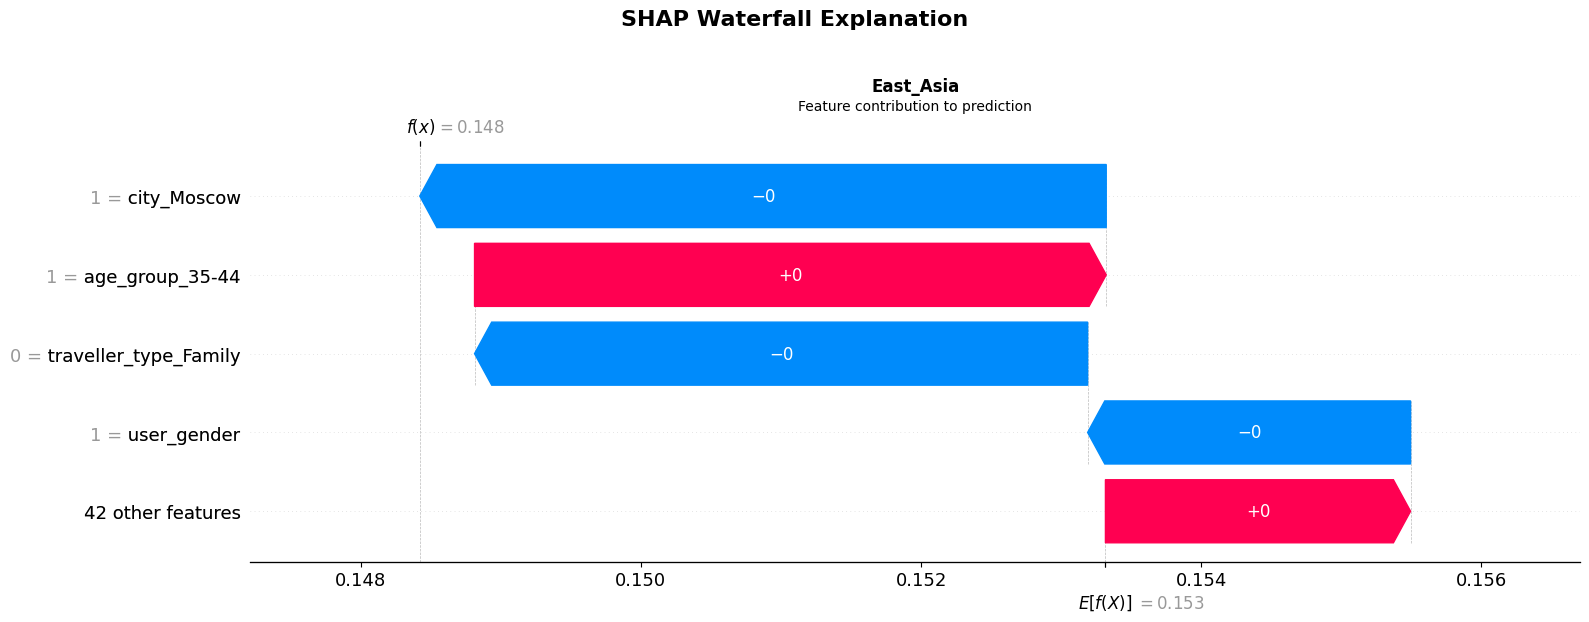

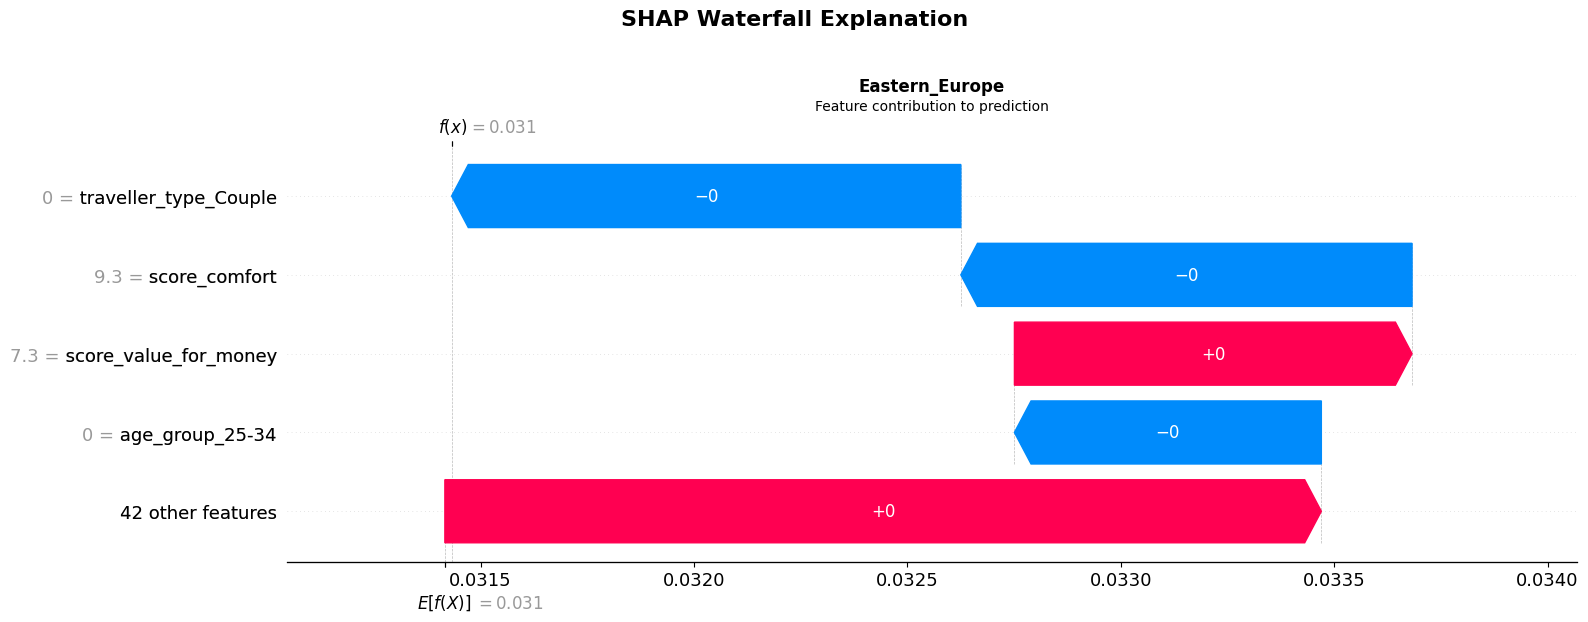

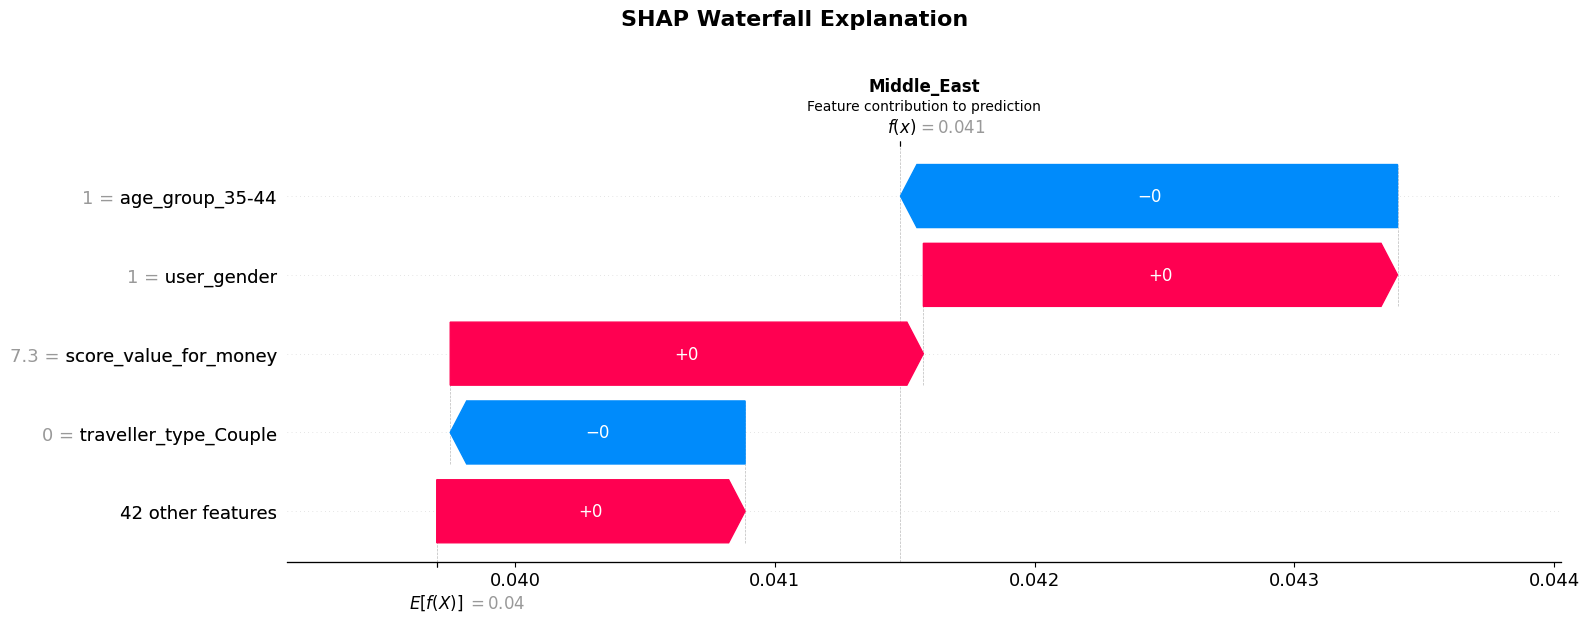

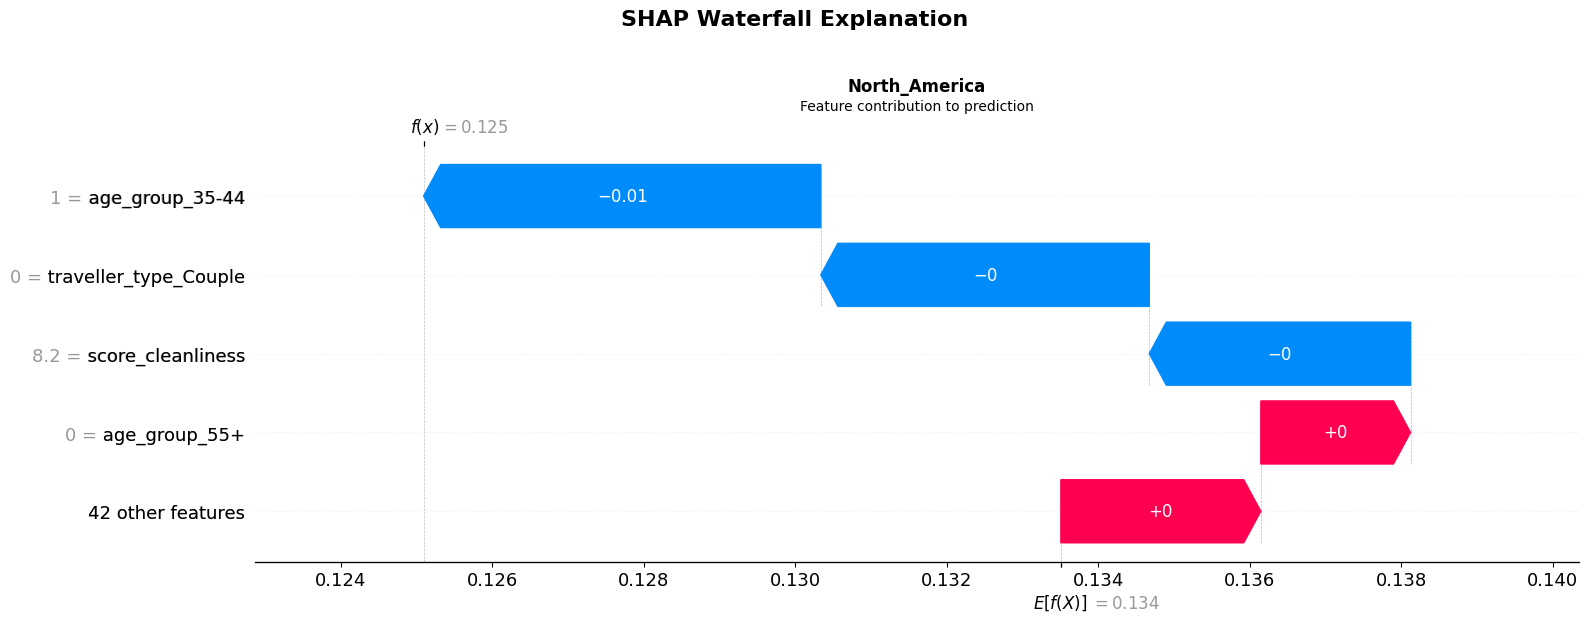

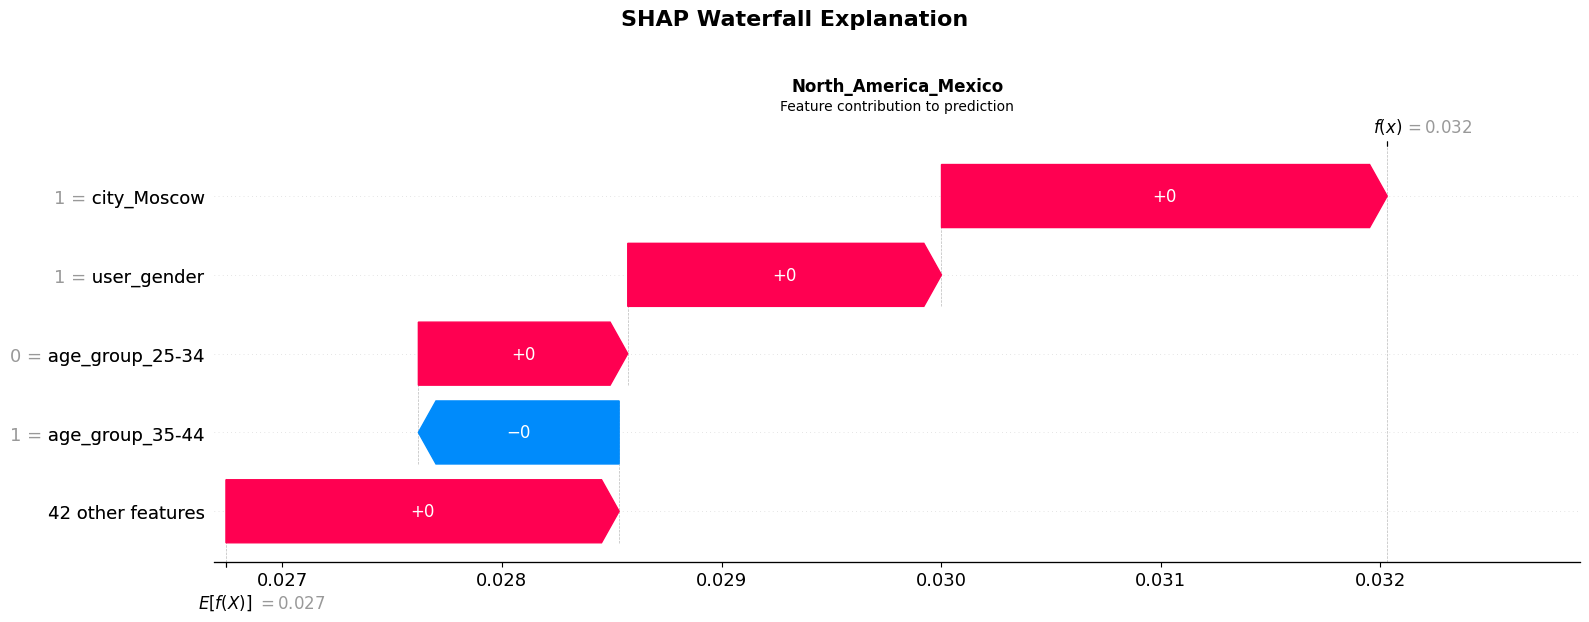

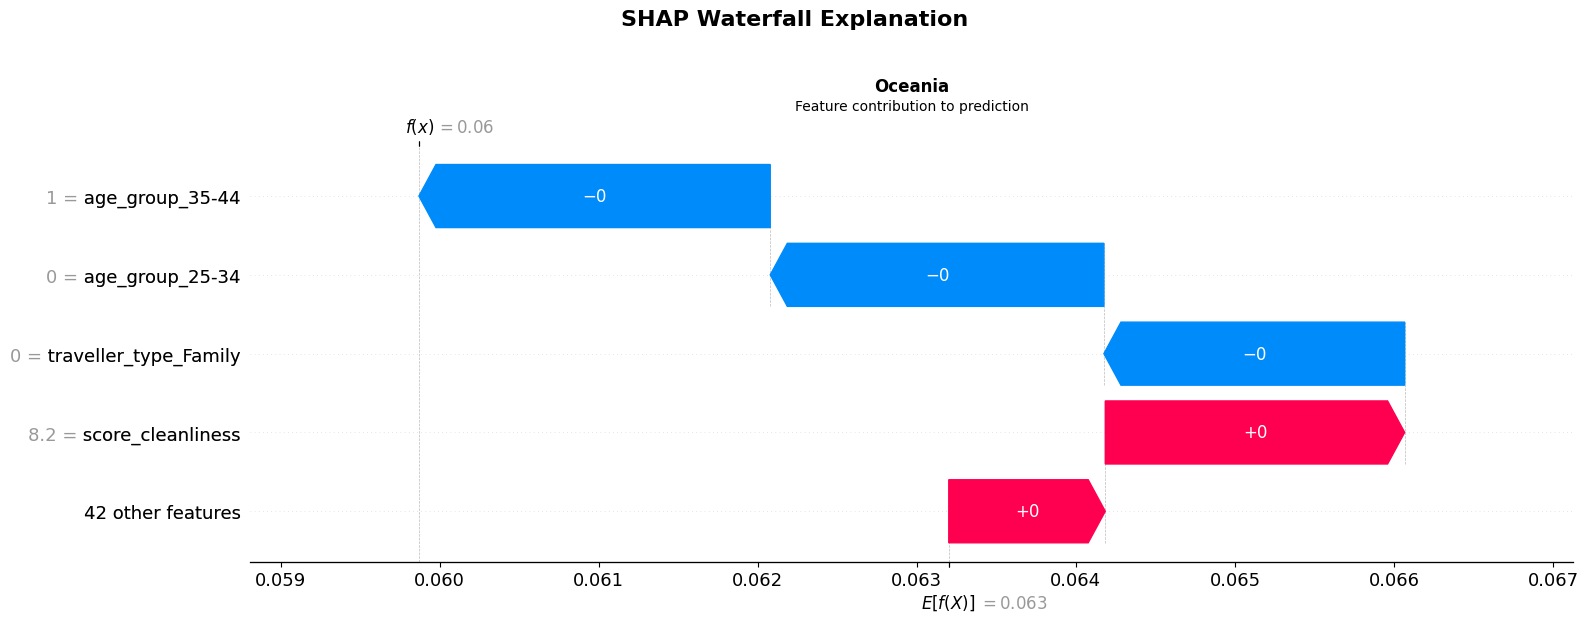

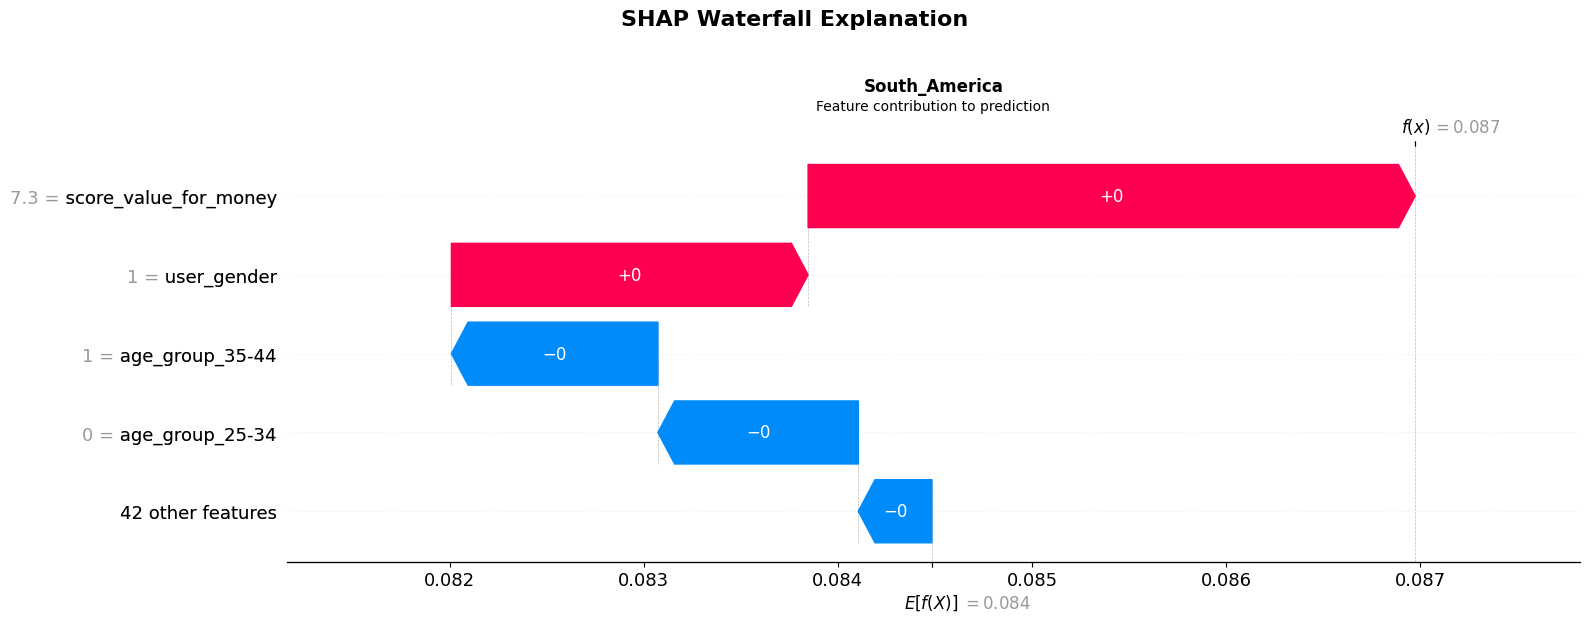

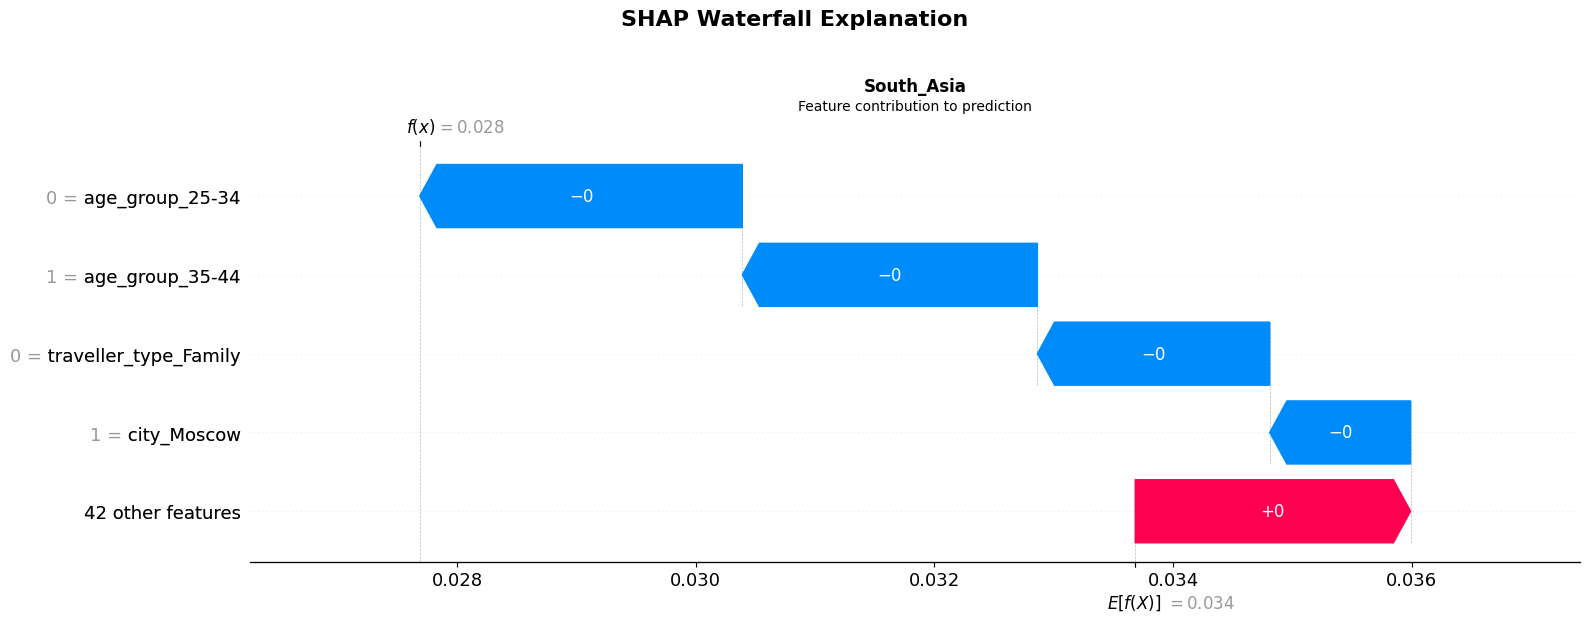

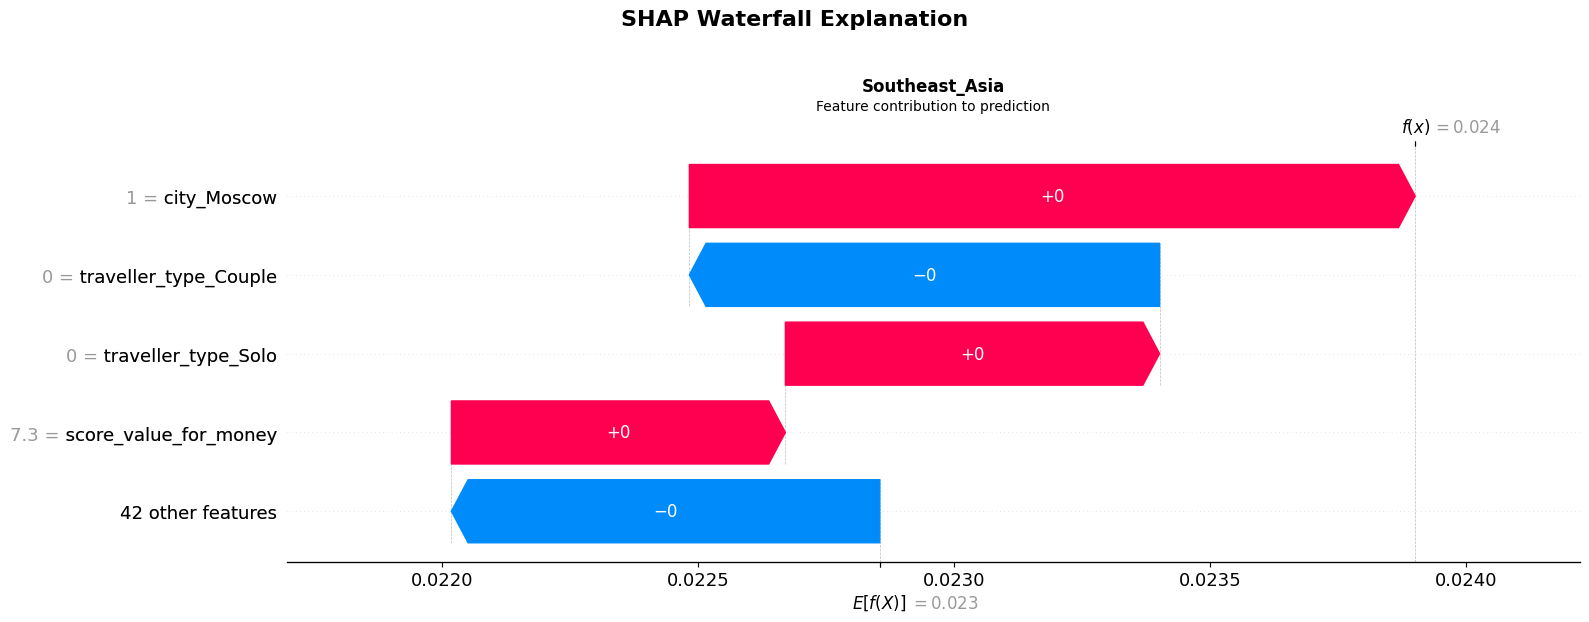

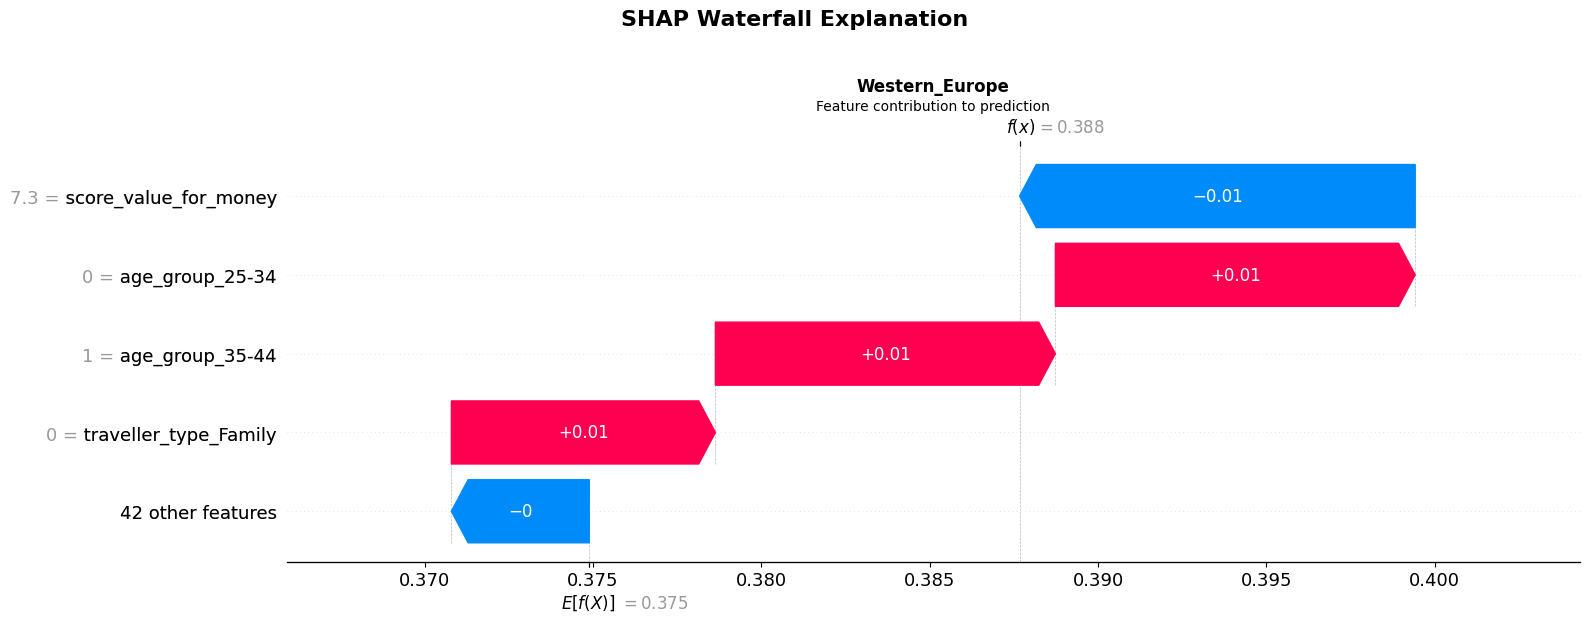

In [23]:

observation = 0

# plt.rcParams['figure.figsize'] = (12, 6)  # default width/height for new figures


for class_idx in range(11):
    # Extract SHAP values for this specific class and observation
    shap_values_class_observation = shap_values[observation, :, class_idx]

    shap.plots.waterfall(shap_values_class_observation, max_display=5, show=False)

    fig = plt.gcf()   # get the current figure
    ax = plt.gca()    # get the current axes

    ax.set_title(f'{class_names[class_idx]}', fontsize=12, fontweight='bold')
    ax.set_xlabel("Feature contribution to prediction")
    fig.suptitle("SHAP Waterfall Explanation", fontsize=16, fontweight="bold", y=1.03)
    plt.gcf().set_size_inches(16, 6)

    plt.tight_layout()
    plt.show()

    display(shap.plots.force(shap_values_class_observation))